In this tutorial, we'll run some statistical tests to demonstrate the 'spatial autocorrelation' that is present among genes in spatial transcriptomics data. This spatial dependency is one of the primary reasons why incorporating the spatial structure is so important. Ultimately, we'll see that even a fairly naive incorporation improves clustering results pretty significantly. 

In [58]:
import scanpy as sc
import numpy as np
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
from mclustpy import mclustpy

Let's again use the DLPFC Slice 151673 as our illustrating example

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


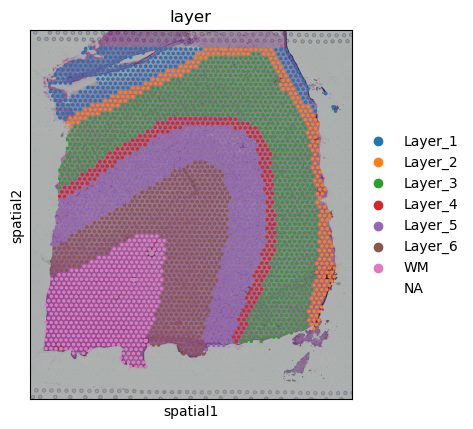

In [59]:
adata = sc.read_h5ad('/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/SpatialTranscriptomics/151673.h5ad')

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]

sc.pl.spatial(adata, color='layer')


### Moran's I for Spatial Autocorrelation of Gene Expression

### Overview

**Moran's I** is a measure of **spatial autocorrelation**, quantifying how similar nearby gene expression values are in a spatial context. It ranges from **-1** (perfect dispersion) to **1** (perfect clustering), with **0** indicating spatial randomness.

In the context of **spatial transcriptomics**, Moran's I can be used to determine whether a gene's expression values exhibit spatial structure by leveraging an **expression vector** $x$ and a spatial **adjacency matrix** $A$ describing spatial relationships between spots or cells (i.e. if those spots are nearby one another on the tissue).

---

### Definition of Moran's I

Given:

A **gene expression vector** $x$ of size $n$, where $x_i$ represents the expression of that gene at spatial location $i$ on the tissue (or, rather, in spot $i$).

An **adjacency matrix** $A$ (or spatial weight matrix) of size $n \times n$, where $A_{ij}$ indicates the spatial relationship between spots $i$ and $j$ (i.e., whether or not those spots are **neighbors** of one another spatially). The adjacency matrix is defined as: 

$$
A_{ij} = 
    \begin{cases} 
    1 & \text{ if spot } i \text{ and } j \text{ are spatial neighbors} \\ 
    0 & \text{ otherwise}. 
    \end{cases}
$$

A **row-normalized** weight matrix $W$ where $W_{ij} = \frac{A_{ij}}{\sum_j A_{ij}}$. Now, the rows all sum to 1.

Moran’s I is then computed as:

$$
I(x) = \frac{x^T W x}{w} \frac{n}{x^T x}
$$

where:
- The first term measures **spatial covariance**, weighted by $W$, and scaled by the sum of all the entries in $W$- $w$.
- The second term then scales the measure of spatial covariance by the overall variance of that vector.

---

### Interpretation

- **$ I > 0 $ (Positive Spatial Autocorrelation)**:  
  - Nearby spots have **similar** expression levels.
  - Suggests spatially structured gene expression.
  - Potentially reflects **spatially regulated** genes.

- **$ I \approx 0 $ (Random Distribution)**:  
  - No significant spatial structure.
  - Expression levels are spatially independent (randomly distributed).

- **$ I < 0 $ (Negative Spatial Autocorrelation)**:  
  - Nearby spots have **dissimilar** expression.
  - Suggests spatial patterning with alternating high/low expression.


In [60]:
############## First, how to calculate Moran's I for a given gene x with spatial relations W ##############
def cal_Morans_I(x,W):
    ''' 
    x = expression vector of gene we care about
    W = spatial adjacency matrix of spots
    '''
    w = np.sum(W)
    n = x.shape[0]
    #I = Moran(x,W)
    I = (x.T @ W @ x) * (1/w) * (n / (x.T @ x + 1e-10)) # add a small term to denominator for stability
    return I

############## Now, how to actually calculate those spatial relations ##############
def Eu_dis(x):
    """
    Calculate the distance among each raw of x
    :param x: N X D
                N: number of samples
                D: Dimension of the feature
    :return: N X N distance matrix
    """
    x = np.asarray(x)
    aa = np.sum(np.multiply(x, x), 1)
    ab = x @ x.T
    dist_mat = aa + aa.T - 2 * ab
    dist_mat[dist_mat < 0] = 0
    dist_mat = np.sqrt(dist_mat)
    dist_mat = np.maximum(dist_mat, dist_mat.T)
    dist_mat = np.asarray(dist_mat)
    return dist_mat

def cal_adj(data, n_neighbors):
    '''
    Calculate adjacency matrix based on KNN
    For each row of X, put an edge between nodes i and j
    If nodes are among the n_neighbors nearest neighbors of each other
    according to Euclidean distance
    '''
    data = np.array(data)
    dist = Eu_dis(data)
    n = dist.shape[0]
    W_L = np.zeros((n, n))
    for i in range(n):
        index_L = np.argsort(dist[i, :])[1:1 + n_neighbors] 
        len_index_L = len(index_L)
        for j in range(len_index_L):
            W_L[i, index_L[j]] = 1 
    W_L = np.maximum(W_L, W_L.T)
    # Row-normalization step
    row_sums = W_L.sum(axis=1, keepdims=True)  
    row_sums[row_sums == 0] = 1  
    W_L = W_L / row_sums  
    return W_L


We also want to measure how statistically significant this spatial autocorrelation is. In other words, could it have just occurred randomly? 

### **Permutation Test for Moran’s I**
1. **Moran’s I alone is not enough**  
   - A raw Moran’s I value indicates **the degree of spatial autocorrelation**, but we need to assess whether this value is statistically significant.
  
2. **Comparison Against a Null Distribution**  
   - The permutation test helps construct a **null distribution** of Moran’s I values by randomly shuffling $x$ while keeping the spatial structure ($W$) fixed.
   - This **breaks any spatial dependence** in the data while preserving the overall variance and distribution of $x$.

3. **Interpretation of Significance**  
   - If the observed Moran’s I is **much larger** than expected under the null hypothesis, then we conclude that spatial autocorrelation is **unlikely due to chance**.
   - A **p-value** tells us the probability of obtaining an equal or more extreme Moran’s I under random permutations.

---

### **Steps of a Permutation Test for Moran’s I**

### **1. Compute the Observed Moran’s I**
Calculate the Moran’s I value for the given gene expression vector $x$ and spatial weight matrix $W$:

$$
I_{\text{obs}} = \frac{x^T W x}{w} \frac{n}{x^T x}
$$

where:
- $W$ is the spatial weight matrix (adjacency-based),
- $w = \sum_{i} \sum_{j} W_{ij}$ is the sum of all spatial weights,
- $n$ is the number of spatial locations.

### **2. Generate a Null Distribution (Permutation Step)**
- Randomly **shuffle** the gene expression values in $x$, creating a permuted vector $x_{\text{perm}}$.
- Compute Moran’s I for each shuffled vector:

$$
I_{\text{perm}}^{(k)} = \frac{x_{\text{perm}}^{(k)T} W x_{\text{perm}}^{(k)}}{w} \frac{n}{x_{\text{perm}}^{(k)T} x_{\text{perm}}^{(k)}}
$$

- Repeat for **many** permutations (e.g., 1,000 or 10,000 times) to build an **empirical null distribution** of Moran’s I.

### **3. Compute the Z-Score**
The **z-score** standardizes the observed Moran’s I relative to the null distribution:

$$
Z = \frac{I_{\text{obs}} - \mu_{\text{perm}}}{\sigma_{\text{perm}}}
$$

where:
- $\mu_{\text{perm}}$ is the **mean** of the permuted Moran’s I values,
- $\sigma_{\text{perm}}$ is the **standard deviation** of the permuted Moran’s I values.

A **high z-score** (e.g., $Z > 2$) suggests the observed spatial autocorrelation is much greater than expected under randomness.

### **4. Compute the P-Value**
The **p-value** quantifies how extreme the observed Moran’s I is under the null hypothesis:

$$
p = \frac{\text{\# of permutations with } I_{\text{perm}} \geq I_{\text{obs}}}{\text{total permutations}}
$$

This is the **fraction of randomized Moran’s I values** that are **greater than or equal to** the observed value.

- **If $p \ll 0.05$**, we reject the null hypothesis and conclude that $x$ exhibits significant spatial autocorrelation.
- **If $p \approx 1$**, the observed pattern is likely due to random chance.

---

### **What Does the Permutation Test Mean?**
- **Low p-value & high z-score ($Z > 2$, $p < 0.05$)**:
  - Strong evidence of **true spatial autocorrelation** in gene expression.
  - Suggests gene expression is influenced by spatial effects, such as **local tissue environments** or **biological gradients**.
  
- **High p-value & low z-score ($Z \approx 0$, $p \approx 1$)**:
  - No significant spatial pattern.
  - The observed Moran’s I is likely **due to random chance**.
  
- **Negative Moran’s I with significance**:
  - Indicates a strong alternating spatial pattern (e.g., **checkerboard-like pattern in tissue**).

---

In [61]:
# Permute Moran's I
def permute_moran(x, W):
    """ Permutation test: Shuffle x and compute Moran's I """
    permuted_x = np.random.permutation(x)  # Shuffle gene expression
    return cal_Morans_I(permuted_x, W)  # Compute Moran’s I for permuted x

# Compute Z-score for Moran’s I
def cal_z_score(x, W, permutations=1000):
    """ Compute the Z-score for Moran's I using permutation-based null distribution """
    # Compute the observed Moran’s I
    I_obs = cal_Morans_I(x, W)
    # Generate a null distribution via permutation
    I_permuted = np.array([permute_moran(x, W) for _ in range(permutations)])
    # Compute expected squared I and std deviation
    E_I2 = np.mean(I_permuted ** 2)
    std_I = np.std(I_permuted)
    # Compute z-score 
    z = (I_obs - E_I2) / std_I
    print(f"Mean I (Null): {np.mean(I_permuted)}")
    print(f"Std I (Null): {np.std(I_permuted)}")
    print(f"Observed Moran's I: {I_obs}")
    return z, I_permuted  

# Compute P-Value
def cal_p_val(z):
    """ Compute the p-value for the z-score of Moran's I """
    p_value = norm.cdf(z) if z < 0 else (1 - norm.cdf(z))

    if p_value < 0.05:
        if z > 0:
            print("Significant positive spatial autocorrelation (Moran's I > 0)")
        else:
            print("Significant negative spatial autocorrelation (Moran's I < 0)")
    else:
        print("No significant spatial autocorrelation (random spatial distribution)")
    return p_value

If we measure Moran's I on some of the genes, we get a measure of how clustered those genes are spatially versus how randomly distributed they are spatially, as well as the statistical significance of this structure. 

Morans I = 0.4481291399980781 for Gene NEFH
Mean I (Null): 0.3152810241890533
Std I (Null): 0.006475730446477042
Observed Moran's I: 0.4481291399980781
Z Score = 53.84490345629775


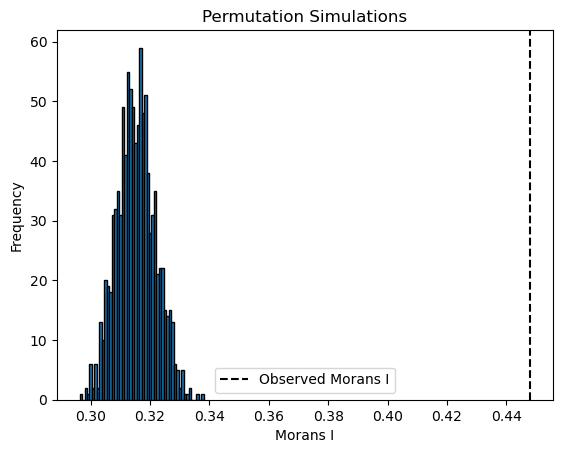

Significant positive spatial autocorrelation (Moran's I > 0)
P Value = 0.0


In [62]:
gene_of_interest = 'NEFH'
X_spatial = adata.obsm["spatial"]
x = adata[:, adata.var_names == gene_of_interest].X
if isinstance(x, scipy.sparse.spmatrix):
    x = x.toarray().flatten()
else:
    x = x.flatten()
W = cal_adj(X_spatial, 6)
# Morans I
I = cal_Morans_I(x,W)
print(f"Morans I = {I} for Gene {gene_of_interest}")
# z Score
z_score_I = cal_z_score(x, W)
z_score = z_score_I[0]
I_squares = z_score_I[1]
print(f"Z Score = {z_score}")
# Create a histogram
plt.hist(I_squares, bins=50, edgecolor='black')
plt.axvline(x=I, color='black', linestyle='--', label='Observed Morans I')
plt.title('Permutation Simulations')
plt.xlabel('Morans I')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#p values
p_val = cal_p_val(z_score)
print(f"P Value = {p_val}")

Now, how is this gene actually distributed on the tissue? Does it seem to form spatial clusters?

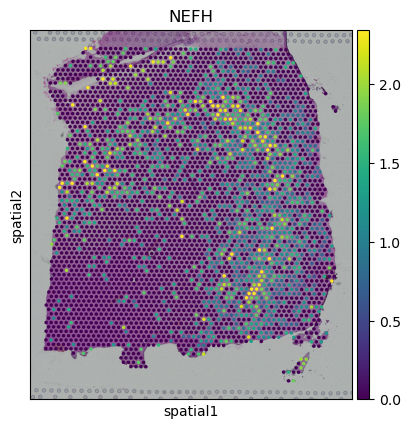

In [63]:
sc.pl.spatial(adata, color='NEFH', vmax='p99')

What is the overall distribution of Moran's I measures across all our genes? Are the genes generally spatially autocorrelated? 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


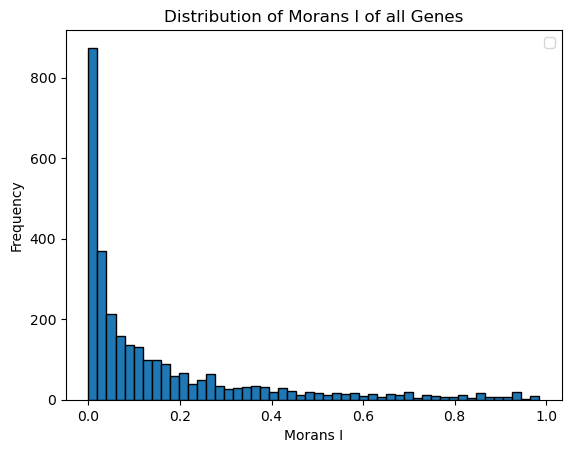

In [64]:
morans_Is = []
for gene in adata.var_names:
    x = adata[:, adata.var_names == gene].X
    if isinstance(x, scipy.sparse.spmatrix):
        x = x.toarray().flatten()
    else:
        x = x.flatten()
    morans_Is.append(cal_Morans_I(x,G))

# Create a histogram
plt.hist(morans_Is, bins=50, edgecolor='black')
plt.title('Distribution of Morans I of all Genes')
plt.xlabel('Morans I')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We want to incorporate this spatial adjacency information into our construction of the covariance matrix for PCA. There is a more detailed mathematical derivation of these steps in a paper I will share with you guys, but here are the broad strokes. 

**Moran’s I–weighted PCA** is a **spatially informed principal component analysis (PCA)** approach that incorporates spatial relationships into dimensionality reduction. By modifying the standard **PCA covariance matrix** with a spatial weight matrix $W$, this method emphasizes spatially structured gene expression patterns.

Given:
- A **gene expression matrix** $X$, where each row represents a **spatial location** (e.g., spots or cells) and each column represents a **gene**.
- A **spatial weight matrix** $W$, derived from an adjacency matrix or other spatial relationships.

Instead of computing the usual **covariance matrix**:

$$
\Sigma = X^T X,
$$

we introduce **spatial weighting** via $W$:

$$
\Sigma_W = X^T W X.
$$

This weighting modifies PCA to **prioritize spatially structured variance**, making the principal components (PCs) more reflective of spatial relationships.

---

## **Mathematical Formulation**

### **1. Standard PCA Covariance**

For a **centered** gene expression matrix $X$ (i.e., mean-subtracted across rows):

$$
\Sigma = \frac{1}{n} X^T X.
$$

Standard **PCA** finds **eigenvectors** and **eigenvalues** of $\Sigma$:

$$
\Sigma v = \lambda v.
$$

where:
- $v$ are **principal components (PCs)**.
- $\lambda$ are **variance contributions (eigenvalues)**.

### **2. Moran’s I–Weighted PCA**

To incorporate **spatial structure**, we weight $X$ by a spatial matrix $W$:

$$
\Sigma_W = X^T W X.
$$

Here:
- $W$ is the **row-normalized** from an **adjacency matrix** $A$.
- Entries $W_{ij}$ capture spatial connectivity 
- Eigenvectors of $\Sigma_W$ provide **spatially aware principal components**.

### **3. Eigenvalue Problem**

The new PCA formulation solves:

$$
\Sigma_W v = \lambda v.
$$

This **favors spatially structured components**, as $W$ amplifies spatially autocorrelated gene expression.


In [67]:
def sPCA_Algorithm(X, W, k, n):
    # Spatially weighted covariance matrix
    Z = (1 / (2*n)) * X.T @ (W+W.T) @ X
    # cal Q (Projected Data Matrix)
    Z_eigVals, Z_eigVects = np.linalg.eig(np.asarray(Z))
    eigValIndice = np.argsort(Z_eigVals)[::-1]
    n_eigValIndice = eigValIndice[0:k]
    n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
    # Optimal Q given by eigenvectors corresponding
    # to largest k eigenvectors
    V = np.array(n_Z_eigVect)
    return V

We can then compare the performance of this new spatially weighted PCA to standard PCA using different clustering techniques

In [85]:
# PCA
adata_pca = adata.copy()
sc.tl.pca(adata_pca, n_comps=50)
sc.pp.neighbors(adata_pca, n_neighbors=10)
sc.tl.louvain(adata_pca, resolution=1.0)
sc.tl.leiden(adata_pca, resolution=1.0)

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


[<Axes: title={'center': 'Leiden NMI = 0.47937747870819397'}, xlabel='spatial1', ylabel='spatial2'>]

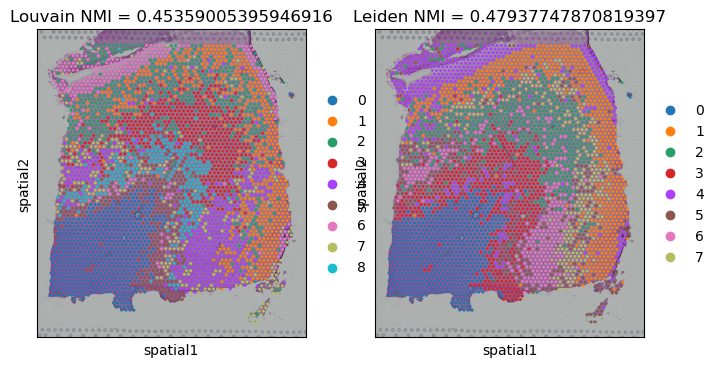

In [86]:
obs_df = adata_pca.obs.dropna()
NMI_louvain = normalized_mutual_info_score(obs_df['louvain'],  obs_df['layer'])
NMI_leiden = normalized_mutual_info_score(obs_df['leiden'],  obs_df['layer'])
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata_pca,color='louvain', show=False, ax=axs[0],cmap='tab10',title=f'Louvain NMI = {NMI_louvain}')
sc.pl.spatial(adata_pca,color='leiden', show=False, ax=axs[1],cmap='tab10',title=f'Leiden NMI = {NMI_leiden}')

In [87]:
# Spatial PCA
X = adata.X
W = cal_adj(adata.obsm['spatial'], 6)
k = 50
n = W.shape[0]
U_spca = sPCA_Algorithm(X, W, k, n)
X_spca = X @ U_spca
adata.obsm['X_spca'] = X_spca
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_spca')
#sc.tl.louvain(adata, resolution=1.0)
#sc.tl.leiden(adata, resolution=1.0)
sc.tl.louvain(adata, resolution=0.7)
sc.tl.leiden(adata, resolution=0.7)

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


[<Axes: title={'center': 'Spatial Leiden NMI = 0.51841859250375'}, xlabel='spatial1', ylabel='spatial2'>]

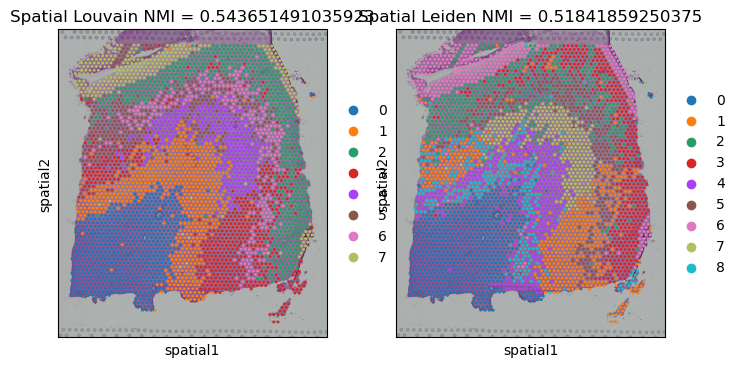

In [88]:
obs_df = adata.obs.dropna()
spatial_NMI_louvain = normalized_mutual_info_score(obs_df['louvain'],  obs_df['layer'])
spatial_NMI_leiden = normalized_mutual_info_score(obs_df['leiden'],  obs_df['layer'])
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata,color='louvain', show=False, ax=axs[0],cmap='tab10',title=f'Spatial Louvain NMI = {spatial_NMI_louvain}')
sc.pl.spatial(adata,color='leiden', show=False, ax=axs[1],cmap='tab10',title=f'Spatial Leiden NMI = {spatial_NMI_leiden}')

In [92]:
print(f'Improvement of ~{np.ceil(((spatial_NMI_louvain - NMI_louvain) / NMI_louvain) * 100)} percent')

Improvement of ~20.0 percent


While this framework does incorporate spatial structure, it still lags in performance behind other more sophisticated methodologies- particularly those utilizing some sort of deep learning architecture. This is what we'll want to explore going forward. There are also better clustering algorithms for this data that we can explore. 